In [18]:
import pandas as pd

# Load dataset
df = pd.read_excel("G:\Projects\product-demand-forecasting\data\Online Retail.xlsx")

# Preview
df.head()

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PAVAN\AppData\Local\Temp\ipykernel_22556\402986498.py:4: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_excel("G:\Projects\product-demand-forecasting\data\Online Retail.xlsx")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df.shape

(541909, 8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [21]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [22]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data Cleaning

In [23]:
# Drop rows with null CustomerID (not useful for modeling)
df = df[df['CustomerID'].notnull()]

# Remove canceled orders (Invoice starts with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantity or price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Feature Creation

In [24]:
# Create total sales column
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Extract date features
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Day'] = df['InvoiceDate'].dt.date

### Sales Analysis

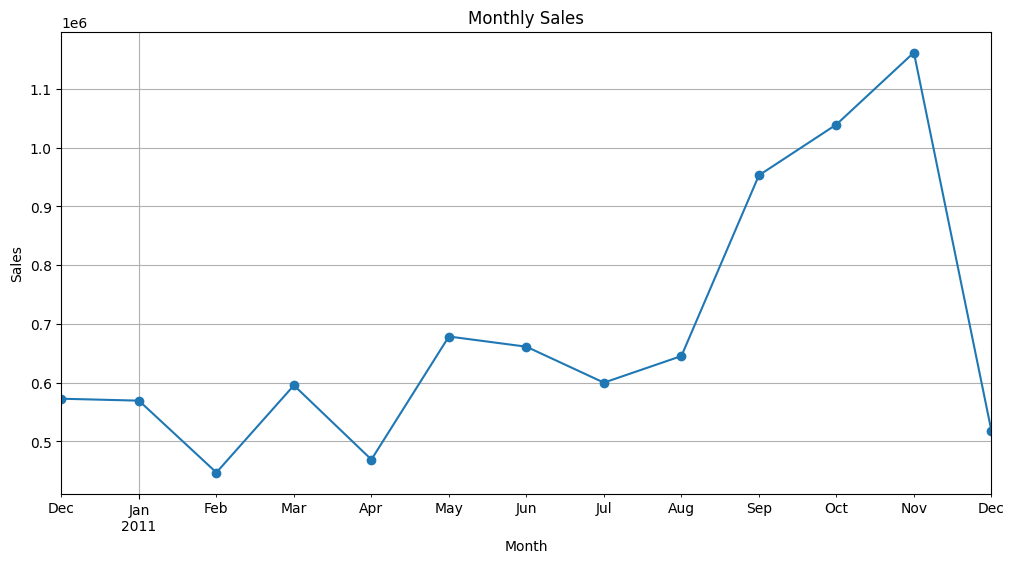

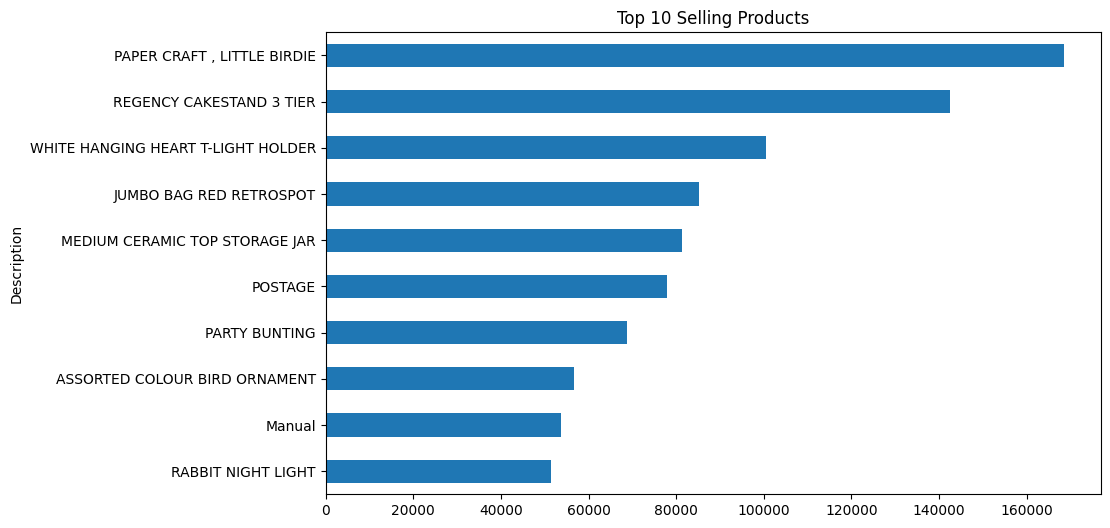

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Monthly Sales
monthly_sales = df.groupby('Month')['Sales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Top 10 Selling Products
top_products = df.groupby('Description')['Sales'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10, 6), title='Top 10 Selling Products')
plt.gca().invert_yaxis()
plt.show()

### Country-wise Sales

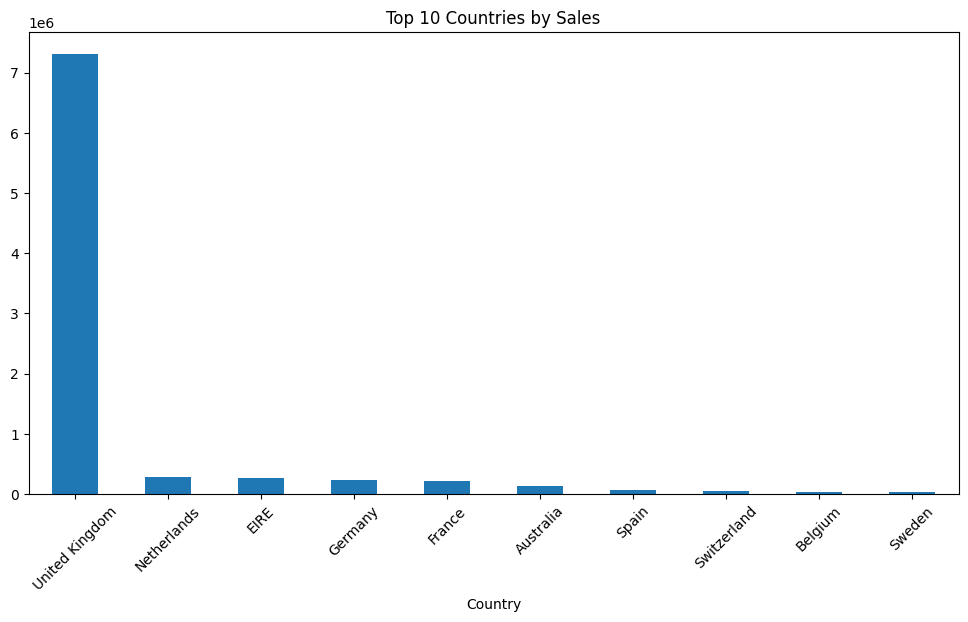

In [26]:
country_sales = df.groupby('Country')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
country_sales.head(10).plot(kind='bar', title='Top 10 Countries by Sales')
plt.xticks(rotation=45)
plt.show()


### Feature Engineering + Model Building (XGBoost)

In [28]:
# group by Date and Product
daily_product_sales = (
    df.groupby([df['InvoiceDate'].dt.date, 'StockCode'])['Sales']
    .sum()
    .reset_index()
    .rename(columns={'InvoiceDate': 'Date'})
)

### Add Lag Features (past 1-day, 7-day sales)

In [30]:
# Convert to datetime
daily_product_sales['Date'] = pd.to_datetime(daily_product_sales['Date'])

# Sort before shifting
daily_product_sales = daily_product_sales.sort_values(['StockCode', 'Date'])

# Create lagged sales feature
daily_product_sales['lag_1'] = daily_product_sales.groupby('StockCode')['Sales'].shift(1)
daily_product_sales['lag_7'] = daily_product_sales.groupby('StockCode')['Sales'].shift(7)

# Drop rows with NaN
daily_product_sales = daily_product_sales.dropna()

### Train/Test Split + XGBoost

In [40]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

# Features and target
features = ['lag_1', 'lag_7']
X = daily_product_sales[features]
y = daily_product_sales['Sales']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = XGBRegressor()
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
print(f"RMSE: {rmse:.2f}")

RMSE: 202.66


### Save the model

In [44]:
import joblib

# Save the model to the 'models/' folder
joblib.dump(model, 'G:\Projects\product-demand-forecasting\models/xgb_sales_model.pkl')

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PAVAN\AppData\Local\Temp\ipykernel_22556\1934491218.py:4: SyntaxWarning: invalid escape sequence '\P'
  joblib.dump(model, 'G:\Projects\product-demand-forecasting\models/xgb_sales_model.pkl')


['G:\\Projects\\product-demand-forecasting\\models/xgb_sales_model.pkl']